In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
import itertools
import os

buoy_root = "../../../data/drifter_data/dataset_forecast_error/area1_presentation_sim"
forecast_root = "../../../data/drifter_data/forecasts/area1"

/home/jonas/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/matplotlib/quiver.py:689: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/jonas/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/matplotlib/quiver.py:689: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


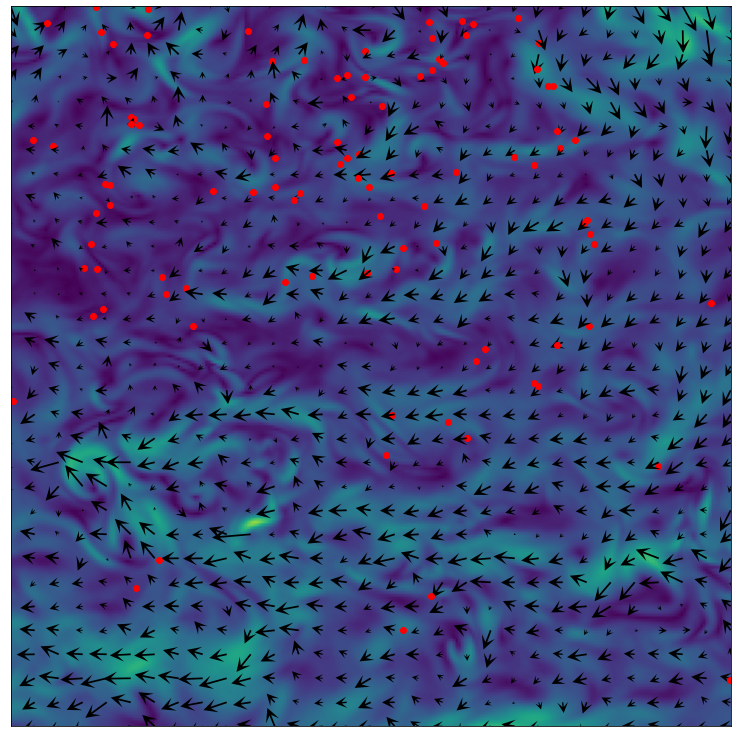

In [13]:
class AnimatedScatter:
    def __init__(self, lon_range, lat_range):
        self.lon_range = lon_range
        self.lat_range = lat_range

        self.buoy_data = None
        self.fc_data = None
        self.load_data()
        self.stream = self.data_stream()

        self.fig, self.ax = plt.subplots(figsize=(10, 10), frameon=False)
        self.fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
        self.anim = animation.FuncAnimation(self.fig, self.update, interval=200, frames=200,
                                            init_func=self.setup_plot, blit=True)
        self.anim.save("/home/jonas/Downloads/animation_test.mp4", fps=30, extra_args=["-vcodec", "libx264"])

    def setup_plot(self):
        # remove ticks and labels
        self.ax.set_yticklabels([])
        self.ax.set_xticklabels([])
        self.ax.set_xticks([])
        self.ax.set_yticks([])

        fc, fc_u, fc_v, buoy = next(self.stream)
        # self.ax = plt.axes(xlim=self.lon_range, ylim=self.lat_range)
        self.im = self.ax.imshow(fc, origin="lower", extent=[*self.lon_range]+[*self.lat_range])
        quiver_data = self.get_quiver_values(fc_u, fc_v)
        self.quiver = self.ax.quiver(quiver_data[0], quiver_data[1], np.zeros(quiver_data[0].shape), np.zeros(quiver_data[0].shape), angles="xy", color="k", headwidth=8, headlength=8)
        self.scat = self.ax.scatter(buoy["lon"], buoy["lat"], color="r")
        return self.scat, self.quiver, self.im

    def load_data(self):
        # get forecasts
        fc_path = os.path.join(forecast_root, sorted(os.listdir(forecast_root))[0])
        fc_data = xr.open_dataset(fc_path)
        self.fc_data = fc_data.sel(longitude=slice(*self.lon_range), latitude=slice(*self.lat_range))
        # get buoy data
        data_path = os.path.join(buoy_root, sorted(os.listdir(buoy_root))[0])
        self.buoy_data = pd.read_csv(data_path)

    def data_stream(self):
        fc_time = 0
        buoy_time = 0
        while True:
            fc_time += 1
            buoy_time += 1
            fc, fc_u, fc_v = self.get_fc_frame(fc_time)
            buoy = self.get_buoy_frame(buoy_time)
            yield fc, fc_u, fc_v, buoy

    def update(self, i):
        fc, fc_u, fc_v, buoy = next(self.stream)
        self.scat.set_offsets(buoy[["lon", "lat"]])
        quiver_values = self.get_quiver_values(fc_u, fc_v)
        self.quiver.set_UVC(quiver_values[2], quiver_values[3])
        self.im.set_data(fc)
        return self.scat, self.quiver, self.im

    def get_buoy_frame(self, time):
        times = sorted(list(set(self.buoy_data["time"])))
        return self.buoy_data[self.buoy_data["time"] == times[time]]

    def get_fc_frame(self, time):
        fc_u = self.fc_data["utotal"].values[time].squeeze()
        fc_v = self.fc_data["vtotal"].values[time].squeeze()
        return np.sqrt(fc_u**2 + fc_v**2), fc_u, fc_v

    def get_quiver_values(self, u_cur=None, v_cur=None, arrow_spacing=8):
        quiver_coord_helper = np.arange(arrow_spacing, u_cur.shape[0], arrow_spacing)
        coords = list(itertools.product(quiver_coord_helper, quiver_coord_helper))
        quiver_x = np.array([pair[0] for pair in coords])
        quiver_y = np.array([pair[1] for pair in coords])
        if u_cur is not None:
            quiver_u = list(u_cur[quiver_y, quiver_x])
        else:
            quiver_u = np.zeros(len(quiver_x))
        if v_cur is not None:
            quiver_v = list(v_cur[quiver_y, quiver_x])
        else:
            quiver_v = np.zeros(len(quiver_x))

        # now need to rescale positions to be in lon and lat range
        quiver_x = AnimatedScatter.map_to_range(quiver_x, np.min(quiver_x), np.max(quiver_x), *self.lon_range)
        quiver_y = AnimatedScatter.map_to_range(quiver_y, np.min(quiver_y), np.max(quiver_y), *self.lat_range)
        return quiver_x, quiver_y, quiver_u, quiver_v

    @staticmethod
    def map_to_range(values, orig_min, orig_max, new_min, new_max):
        orig_span = orig_max-orig_min
        new_span = new_max - new_min

        # map from orig to [0,1] interval
        values_scaled = (values-orig_min)/orig_span

        # map from [0,1] to new range
        return new_min + (values_scaled * new_span)


anim = AnimatedScatter((-146.25, -125), (15, 36.25))
plt.show()
